In [135]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict


In [149]:
def load_graph(path):
    return nx.read_edgelist(path, nodetype=int)

G_ba = load_graph("data/ba.txt")
G_er = load_graph("data/er.txt")

print(G_ba.number_of_nodes())
print(G_er.number_of_nodes())


1000
999


In [137]:
# since betweennes is expensive to compute everytime to get same values, precompute for reuse
bc_ba = nx.betweenness_centrality(G_ba)
bc_er = nx.betweenness_centrality(G_er)

In [138]:
def vaccinate_random(G, k, name="no"):
    return random.sample(list(G.nodes()), k)

def vaccinate_high_degree(G, k, name="no"):
    degree_sorted = sorted(G.degree, key=lambda x: x[1], reverse=True)
    return [node for node, _ in degree_sorted[:k]]

def vaccinate_high_betweenness(G, k, name="no"):
    if name == "no":
        print("wrong graph specification")
        return
    elif name == "BA":
        bc = bc_ba
    elif name == "ER":
        bc = bc_er
    
    sorted_nodes = sorted(bc.items(), key=lambda x: x[1], reverse=True)
    return [node for node, _ in sorted_nodes[:k]]


In [139]:
def sir_simulation(G, vaccinated, beta=0.04, gamma=0.2, time_period=10000):
    # states: 0-S, 1-I, 2-R
    # initalizating all as S
    state = {node: 0 for node in G.nodes()}
    
    #vaccinate the chosen nodes
    for v in vaccinated:
        state[v] = 2
    
    #choosing patient zero from the unvaccinated nodes
    susceptible_nodes = [n for n in G.nodes() if state[n] == 0]
    patient_zero = random.choice(susceptible_nodes)
    state[patient_zero] = 1

    # infected over time
    infected_counts = []

    #over time infection spreads
    for _ in range(time_period):
        
        new_state = state.copy()
        infected_now = [n for n in G.nodes() if state[n] == 1]
        infected_counts.append(len(infected_now))
        
        #if no infected the pandemic ends
        if len(infected_now) == 0:
            break
        
        
        for node in infected_now:
            # infecting neighbor with infection rate beta
            for nbr in G.neighbors(node):
                if state[nbr] == 0 and random.random() < beta:
                    new_state[nbr] = 1

            # from the infected recover with rate of gamma
            if random.random() < gamma:
                new_state[node] = 2

        state = new_state
    # never infected nodes that was not vaccinated length
    never_infected = len([n for n in G.nodes() if state[n] == 0])
    # unique infected nodes length
    unique_infected = len([n for n in G.nodes() if state[n] == 2 and n not in vaccinated])
    
    return infected_counts, never_infected, unique_infected


In [140]:
def run_experiment(G, k, strategy_fn, g_name, runs=100):
    infected_per_sim = []
    never_infected_per_sim = []
    unique_infected_per_sim = []
    
    for _ in range(runs):
        # try diff stratgeies and get the vaccinated nodes
        vaccinated = strategy_fn(G, k, g_name)
        infected_overtime, never_infected, unique_infected = sir_simulation(G, vaccinated)
        infected_per_sim.append(sum(infected_overtime))  # total sum of infected over time per run (can be duplicates)
        never_infected_per_sim.append(never_infected)
        unique_infected_per_sim.append(unique_infected)
    
    return infected_per_sim, never_infected_per_sim, unique_infected_per_sim

In [141]:
strategies = {
    "Random": vaccinate_random,
    "High-degree": vaccinate_high_degree,
    "High-betweenness": vaccinate_high_betweenness
}

k = 50
runs = 100

results = {}

for net_name, G in [("BA", G_ba), ("ER", G_er)]:
    print(f"{net_name} network")
    print(f"Nodes: {G.number_of_nodes()}")
    results[net_name] = {}

    for strat_name, strat_fn in strategies.items():
        infected_time, never_inf, unique_inf = run_experiment(G, k, strat_fn, net_name, runs)

        results[net_name][strat_name] = {
            "unique_infected": np.mean(unique_inf),
            "never_infected": np.mean(never_inf),
            "auc_infected": np.mean(infected_time)
        }

        print(f"{strat_name:16s} | "
              f"Unique infected: {np.mean(unique_inf):7.1f} | "
              f"Over time infected: {np.mean(infected_time):7.1f} | "
              f"Never infected: {np.mean(never_inf):7.1f}")

BA network
Nodes: 1000
Random           | Unique infected:   208.4 | Over time infected:  1043.2 | Never infected:   741.6
High-degree      | Unique infected:     1.7 | Over time infected:     8.8 | Never infected:   948.3
High-betweenness | Unique infected:     2.4 | Over time infected:    11.4 | Never infected:   947.6
ER network
Nodes: 999
Random           | Unique infected:   116.7 | Over time infected:   587.5 | Never infected:   832.3
High-degree      | Unique infected:    74.5 | Over time infected:   375.4 | Never infected:   874.5
High-betweenness | Unique infected:    62.0 | Over time infected:   313.1 | Never infected:   887.0


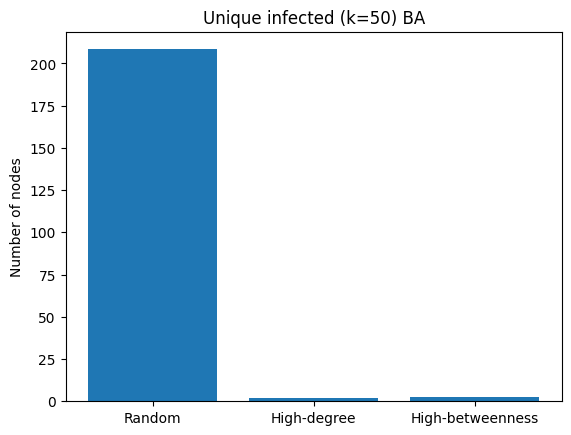

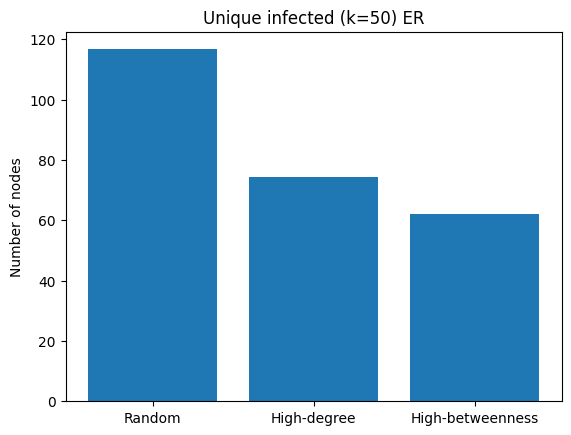

In [142]:
labels = list(strategies.keys())

for net in results:
    vals = [results[net][s]["unique_infected"] for s in labels]

    plt.figure()
    plt.bar(labels, vals)
    plt.title(f"Unique infected (k={k}) {net}")
    plt.ylabel("Number of nodes")
    plt.show()


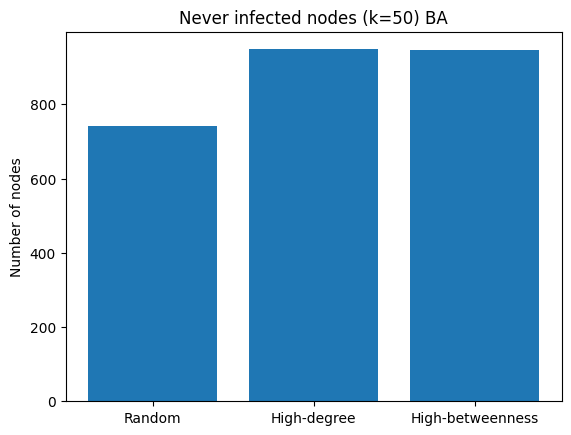

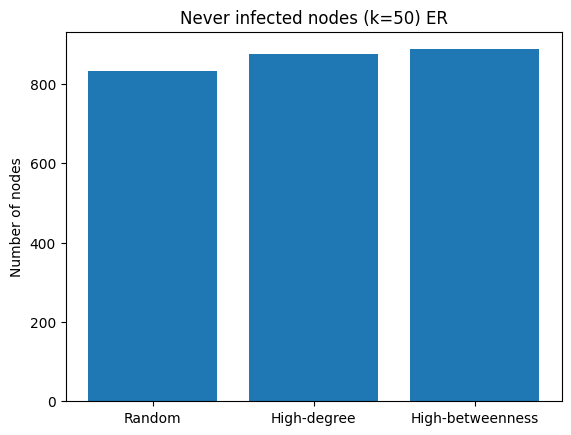

In [143]:
for net in results:
    vals = [results[net][s]["never_infected"] for s in labels]

    plt.figure()
    plt.bar(labels, vals)
    plt.title(f"Never infected nodes (k={k}) {net}")
    plt.ylabel("Number of nodes")
    plt.show()


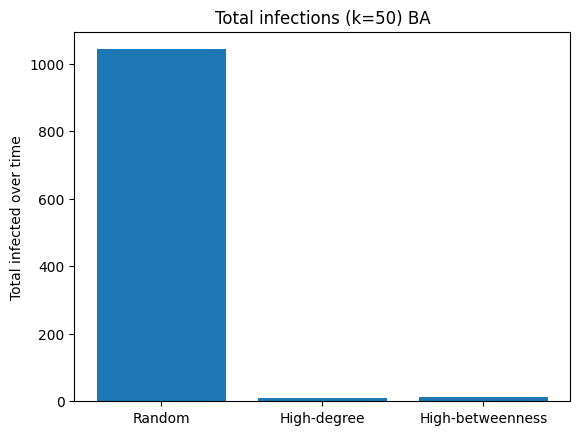

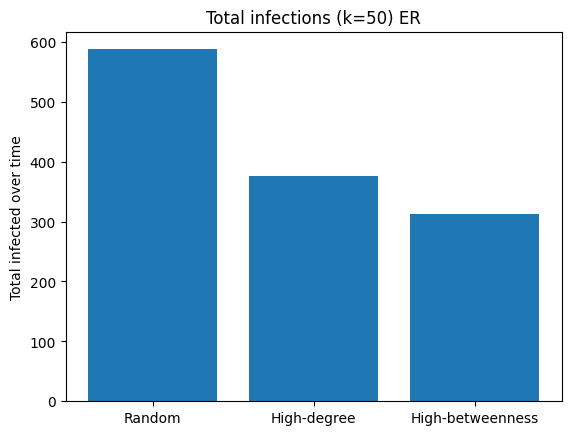

In [144]:
for net in results:
    vals = [results[net][s]["auc_infected"] for s in labels]

    plt.figure()
    plt.bar(labels, vals)
    plt.title(f"Total infections (k={k}) {net}")
    plt.ylabel("Total infected over time")
    plt.show()


In [145]:
def average_infected_curve(G, strategy_fn, g_name, k, runs=100):
    curves = []
    max_len = 0

    for _ in range(runs):
        vaccinated = strategy_fn(G, k, g_name)
        infected_overtime, _, _ = sir_simulation(G, vaccinated)
        curves.append(infected_overtime)
        max_len = max(max_len, len(infected_overtime))

    # pad shorter runs with zeros (epidemic already ended)
    padded_curves = [
        c + [0] * (max_len - len(c)) for c in curves
    ]

    mean_curve = np.mean(padded_curves, axis=0)
    return mean_curve


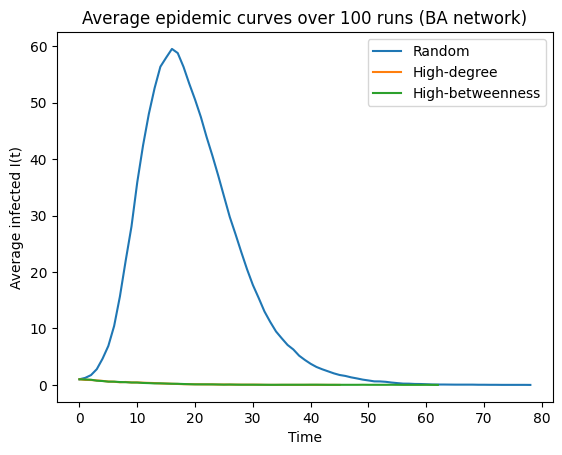

In [146]:
plt.figure()

for strat_name, strat_fn in strategies.items():
    mean_I_t = average_infected_curve(G_ba, strat_fn, "BA", k, runs=100)
    plt.plot(mean_I_t, label=strat_name)

plt.xlabel("Time")
plt.ylabel("Average infected I(t)")
plt.title("Average epidemic curves over 100 runs (BA network)")
plt.legend()
plt.show()


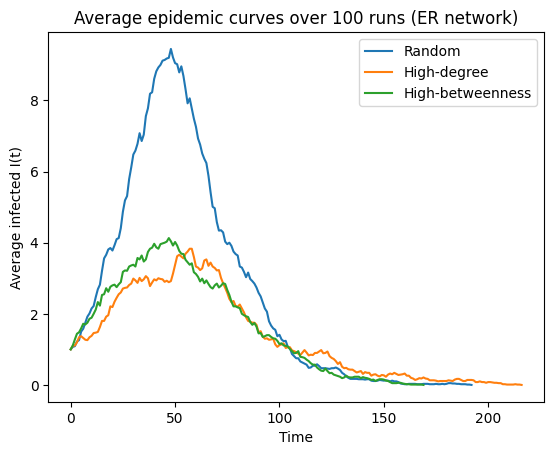

In [147]:
plt.figure()

for strat_name, strat_fn in strategies.items():
    mean_I_t = average_infected_curve(G_er, strat_fn, "ER", k, runs=100)
    plt.plot(mean_I_t, label=strat_name)

plt.xlabel("Time")
plt.ylabel("Average infected I(t)")
plt.title("Average epidemic curves over 100 runs (ER network)")
plt.legend()
plt.show()
